In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import locatingFuncs as lF

import funcs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl

plt.style.use('fancy_plots2.mplstyle')
#plt.style.use('default')

In [2]:
mpl.get_configdir()

'/u/olwitt/.config/matplotlib'

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
print(h_const)

0.6774


# where is tracer parent?

find out, where the tracer parent sits, i.e. whether it's still in the main progenitor or in another galaxy or in the IGM

In [6]:
def location_of_parents(basePath, start_snap, target_snap, tree_ids,\
                        parent_indices, help_offsets, sub_ids, starsInSubOffset_target_snap, gasInSubOffset_target_snap,\
                        numInSub_target_snap, random_frac = 1):
    """first output returns the subhalo index if the tracer parent particle sits in a galaxy or -1 if it's in the IGM
    second output states, whether parent particle is inside main progenitor at target snapshot"""
    
    start = time.time()
    
    assert random_frac > 0 and random_frac <= 1, 'random fraction has to be > 0 and <= 1!'
    #load number of particles per galaxy to avoid classifying parents as bound to a galaxy 
    #while they're in reality "inner fuzz" of a halo
    
    gasNumInSub_target_snap = numInSub_target_snap[:,0].copy()
    starNumInSub_target_snap = numInSub_target_snap[:,4].copy()
    del numInSub_target_snap
    
    #for resoltution comparison reasons: only use <random_frac> fraction of all tracers:
    if random_frac < 1:
        rng = np.random.default_rng()
        random_parent_indices = np.zeros(parent_indices.shape)
        new_help_offsets = np.zeros(help_offsets.shape[0]).astype(int)
        for i in range(0, help_offsets.shape[0] - 1):
            indices = np.arange(help_offsets[i],help_offsets[i+1])
            size = int(indices.size * random_frac)
            new_help_offsets[i+1] = size + new_help_offsets[i]
            if size > 0:
                parent_indices_indices = rng.choice(indices, size, replace = False, shuffle = False).astype(int)
                random_parent_indices[new_help_offsets[i]:new_help_offsets[i+1]] =\
                parent_indices[np.sort(parent_indices_indices)]
    
        help_offsets = new_help_offsets.copy()
        not_zero = np.where(random_parent_indices[:,0] != 0)[0]
        random_parent_indices = random_parent_indices[not_zero,:]
        parent_indices = random_parent_indices.copy()

        assert parent_indices.shape[0] == new_help_offsets[-1]
        assert new_help_offsets[0] == 0
        
        del random_parent_indices, new_help_offsets
        
    #find parent index in offset files in NlogM
    location = lF.searchsorted_gas_stars(parent_indices, gasInSubOffset_target_snap, gasNumInSub_target_snap,\
                                               starsInSubOffset_target_snap, starNumInSub_target_snap)
    
    time_locating = time.time()
    
#     print(help_offsets[10481:10484])
#     print(location[help_offsets[10482]:help_offsets[10483]])
#     print(np.where(location[help_offsets[10482]:help_offsets[10483]] == -1)[0].size)
#     print(np.where(location == -1)[0][:1000])
#     print(parent_indices[np.where(location == -1)[0],0][:1000])
    
    #now identify parents that are still in their (main progenitor) galaxy
    
    isInMP = np.empty(parent_indices.shape[0],dtype = bool)
    isInMP.fill(False)
    tree_check = list(tree_ids)
    
    #determine missing trees:
    missing = []
    counter = 0
    
    for i in nb.prange(sub_ids[-1]):
        if i != tree_check[counter]:
            missing.append(i)
            i += 1
            continue
        counter += 1
    
    test = 0
    for j in nb.prange(0,help_offsets.shape[0] - 1): #loop over all relevant galaxies at z=0
        #find all associated particles:
        parentIndicesInSub = np.arange(help_offsets[j],help_offsets[j + 1]).astype(int)
        
        if j in missing or parentIndicesInSub.size == 0: #if subhalo hast no tree, skip it and assign "False"
            if j in missing:
                test += parentIndicesInSub.size
            continue
        if tree_ids[sub_ids[j]]['SubfindID'].shape[0] <= start_snap - target_snap: #if tree doesn't reach until target_snap
            test += parentIndicesInSub.size            
            continue
            
        main_prog = tree_ids[sub_ids[j]]['SubfindID'][start_snap - target_snap]
        where = np.where(location[parentIndicesInSub] == main_prog)[0] + parentIndicesInSub[0]
        isInMP[where] = True

        #print('main progenitor: ', main_prog)
        #print(location[parentIndicesInSub][:10],location[parentIndicesInSub][-10:])
        
        if target_snap == 99:
            assert (np.where(location[parentIndicesInSub] == main_prog)[0].shape[0]) == parentIndicesInSub.shape[0],\
            'offsets wrong probably'   
            assert isInMP[parentIndicesInSub].all() == True, 'offsets wrong probably'
    
    time_isInMP = time.time()
    
    return location, isInMP, help_offsets, time_locating - start, time_isInMP - start

In [7]:
def save_location(basePath, start_snap = 99):
    start = time.time()
    h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']

    num_subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloMass']).shape[0]
    sub_ids = np.arange(num_subs)
    
    #load all MPBs
    tree_ids = loadMPBs(basePath,start_snap,ids = sub_ids, fields=['SubfindID'])
    
    snap = np.arange(99,1,-1)
    
    n = snap.size

    #necessary offsets, when not every tracer is important:
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath, start_snap)
    f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + '/parent_indices_99.hdf5','r')
    parent_indices = f['snap_099/parent_indices'][:,0]
    num_tracers = parent_indices.shape[0]
    del parent_indices
    
    #check, whether old variable names are used
    if f.__contains__('snap_099/numTracersInParents'):
        numTracersInParents = f['snap_099/numTracersInParents'][:]
    else:
        numTracersInParents = f['snap_099/tracers_in_parents_offset'][:]
    f.close()
    
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
    parentsInSubOffset  = np.insert(parentsInSubOffset, 0, 0)
    
    tot_time = 0
    tot_time_locating = 0
    tot_time_isInMP = 0
    
    save_file = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + '/subhalo_index_table.hdf5','w')
    
    for i in range(n):
        start_loop = time.time()
        
        f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + f'/parent_indices_{snap[i]}.hdf5','r')
        parent_indices = f[f'snap_099/parent_indices'][:,:]       
        f.close()    
        if snap[i] < 10:
            str_snap = f'0{snap[i]}'
        else:
            str_snap = str(snap[i])
        
        g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str_snap + '.hdf5','r')
        starsInSubOffset_target_snap = g['Subhalo/SnapByType'][:,4]
        gasInSubOffset_target_snap = g['Subhalo/SnapByType'][:,0]
        g.close()
        
        numInSub_target_snap = il.groupcat.loadSubhalos(basePath, snap[i],fields=['SubhaloLenType'])
        
        grp = save_file.create_group('snap_0'+str_snap)
        
        #run function to determine location of parents
        location, isInMP, _ , time_locating, time_isInMP=\
        location_of_parents(basePath, start_snap = 99, target_snap = snap[i], tree_ids = tree_ids,\
                            parent_indices = parent_indices, help_offsets = parentsInSubOffset, sub_ids = sub_ids,\
                            starsInSubOffset_target_snap = starsInSubOffset_target_snap,\
                            gasInSubOffset_target_snap = gasInSubOffset_target_snap,\
                           numInSub_target_snap = numInSub_target_snap, random_frac = 1)
        
        ds = grp.create_dataset('location', data = location)
        ds2 = grp.create_dataset('isInMP', data = isInMP)
            
        end_loop = time.time()
        tot_time += (end_loop - start_loop)
        tot_time_locating += time_locating
        tot_time_isInMP += time_isInMP
        
        print(snap[i], 'done;',end = ' ')
    print('\n average total time per snapshot: ', tot_time/n)
    print('average time for locating per snapshot: ', tot_time_locating/n)
    print('average time for checking MPB per snapshot: ', tot_time_isInMP/n)
    print('total time: ', end_loop - start)
    save_file.close()    
    
    return

In [8]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
#save_location(basePath)

In [32]:
f = h5py.File('files/TNG50-2/subhalo_index_table.hdf5','r')
print(f.__contains__('snap_099/isInMpP'))
f.close()

False


In [46]:
def fracs_w_mass_bins(basePath, sub_ids, start_snap = 99, random_frac = 1):
    start = time.time()
    h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
    
    snap = np.arange(99,1,-1)
    
    n = snap.size
    
    z = np.zeros(n)
    
    mp = np.zeros(n)
    igm = np.zeros(n)
    sub = np.zeros(n)
    total = np.zeros(n)

    nums = np.zeros((n,5,3))
    
    gal_comp = np.zeros((n,sub_ids.shape[0],3)) #galaxy composition

    #necessary offsets, when not every tracer is important:
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath, start_snap)
#     f = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
    f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + f'/parent_indices_{start_snap}.hdf5','r')

    parent_indices = f[f'snap_0{start_snap}/parent_indices'][:,0]
    num_tracers = parent_indices.shape[0]
    del parent_indices
    
    #check, whether old variable names are used
    if f.__contains__(f'snap_0{start_snap}/numTracersInParents'):
        numTracersInParents = f[f'snap_0{start_snap}/numTracersInParents'][:]
    else:
        numTracersInParents = f[f'snap_0{start_snap}/tracers_in_parents_offset'][:]  
    
    f.close()
    
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
    parentsInSubOffset  = np.insert(parentsInSubOffset, 0, 0)
    
    help_offsets = np.zeros(sub_ids.shape[0])
    which_indices = np.zeros(num_tracers)
    isGalaxy = np.empty(sub_ids.shape, dtype = bool)
    isGalaxy.fill(False)
    
    before_indices = time.time()
    counter = 0
    
    for i in range(1,sub_ids.shape[0] + 1):
        indcs = np.arange(parentsInSubOffset[sub_ids[i-1]],parentsInSubOffset[sub_ids[i-1]+1])
        if indcs.size > 0:
            isGalaxy[i-1] = True
        which_indices[counter:counter + indcs.shape[0]] = indcs
        help_offsets[i-1] = indcs.shape[0]
        counter += indcs.shape[0]
        
    del indcs#, parentsInSubOffset
        
    #trim zeros at the end:
    which_indices = np.trim_zeros(which_indices,'b').astype(int)
    
    #compute correct offsets:
    ## states, which indices correspond to which subhalo from sub_ids
    help_offsets = np.cumsum(help_offsets).astype(int)
    help_offsets = np.insert(help_offsets,0,0)
    
    #which_indices = np.arange(num_tracers)
    #help_offsets = parentsInSubOffset
    
#     location_file = h5py.File('files/' + basePath[32:39] + '/subhalo_index_table.hdf5','r')
    location_file = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + '/subhalo_index_table.hdf5','r')
    
    start_loop = time.time()
    print('time for indices: ',start_loop-before_indices, flush = True)
    print('before loop: ',start_loop-start, flush = True)
    
    for i in range(n):
        f = h5py.File('/vera/ptmp/gc/olwitt/' + basePath[32:39] + f'/parent_indices_{snap[i]}.hdf5','r')
        parent_indices = f[f'snap_0{snap[i]}/parent_indices'][:,:]
        f.close()
        if i==1:
            start_loop = time.time()
        
        #only consider indices of relevant galaxies        
        parent_indices = parent_indices[which_indices,:]
        
        if(i==1):
            end_files = time.time()
            print('time for loading snap from files: ',end_files-start_loop, flush = True)
        
            
        if snap[i] < 10:
            str_snap = f'0{snap[i]}'
        else:
            str_snap = str(snap[i])
        
        before_locating = time.time()
        
        #load location of parents and isInMP array from file (but only those that we are interested in)
        location = location_file[f'snap_0{str_snap}/location'][:]
        location = location[which_indices]
        isInMP = location_file[f'snap_0{str_snap}/isInMP'][:]
        isInMP = isInMP[which_indices]
        
        
        #only take random fraction out of all tracers to compare different resolutions
        if random_frac < 1:
            rng = np.random.default_rng()
            random_parent_indices = np.zeros(parent_indices.shape)
            new_help_offsets = np.zeros(help_offsets.shape[0]).astype(int)
            for i in range(0, help_offsets.shape[0] - 1):
                indices = np.arange(help_offsets[i],help_offsets[i+1])
                size = int(indices.size * random_frac)
                new_help_offsets[i+1] = size + new_help_offsets[i]
                if size > 0:
                    parent_indices_indices = rng.choice(indices, size, replace = False, shuffle = False).astype(int)
                    random_parent_indices[new_help_offsets[i]:new_help_offsets[i+1]] =\
                    parent_indices[np.sort(parent_indices_indices)]

            help_offsets = new_help_offsets.copy()
            not_zero = np.where(random_parent_indices[:,0] != 0)[0]
            random_parent_indices = random_parent_indices[not_zero,:]
            parent_indices = random_parent_indices.copy()

            assert parent_indices.shape[0] == new_help_offsets[-1]
            assert new_help_offsets[0] == 0
        
            del random_parent_indices, new_help_offsets
        
        if(i==1):
            end_locate = time.time()
            print('total time for locating: ',end_locate-before_locating, flush = True)
        #load stellar masses
        sub_masses_stars = il.groupcat.loadSubhalos(basePath,snap[i],fields=['SubhaloMassType'])[:,4] * 1e10/h_const
        sub_masses_gas = il.groupcat.loadSubhalos(basePath,snap[i],fields=['SubhaloMassType'])[:,0] * 1e10/h_const
        sub_masses = sub_masses_stars + sub_masses_gas #consider baryonic mass, not stellar mass
        
        m_tot = np.sum(sub_masses)
        
        #create mass bins
        mass_bin1 = np.where(np.logical_and(sub_masses != 0, sub_masses < 1e9))[0]
        mass_bin2 = np.where(np.logical_and(sub_masses >= 1e9, sub_masses < 1e10))[0]
        mass_bin3 = np.where(np.logical_and(sub_masses >= 1e10, sub_masses < 1e11))[0]
        mass_bin4 = np.where(np.logical_and(sub_masses >= 1e11, sub_masses < 1e12))[0]
        mass_bin5 = np.where(sub_masses >= 1e12)[0]  
        
        if(i==1):
            end_create_bins = time.time()
            print('total time for creating bins: ',end_create_bins-end_locate, flush = True)
        
        #add numbers to mass bins
        nums[i,:,:], gal_comp[i,:,:] = lF.binning(location, isInMP, help_offsets, mass_bin1, mass_bin2, mass_bin3,\
                                               mass_bin4, mass_bin5)
        
        mp[i] = np.where(isInMP)[0].shape[0]
        igm[i] = np.where(location == -1)[0].shape[0] #by definition igm
        sub[i] = np.where(location != -1)[0].shape[0] #everything not in the igm is in a subhalo (or a FoF halo)
        z[i] = il.groupcat.loadHeader(basePath,snap[i])['Redshift'] 
        total[i] = igm[i] + sub[i]
        if(i==1):
            end_binning = time.time()
            print('total time for binning: ',end_binning-end_create_bins, flush = True)
            print('total time for first loop: ',end_binning-start_loop, flush = True)
        print(snap[i],' done;',end=' ',flush=True)
    gal_comp = gal_comp[:,np.nonzero(isGalaxy)[0],:]
    location_file.close()
    return mp, igm, sub, total, nums, z, gal_comp, isGalaxy

In [47]:
@njit
def binning(location, isInMP, help_offsets, mass_bin1, mass_bin2, mass_bin3, mass_bin4, mass_bin5):
    res = np.zeros((5,3))
    gal_res = np.zeros((help_offsets.shape[0] - 1,3))
    
    #determine mass fractions for every galaxy individually
    for i in range(0,help_offsets.shape[0] - 1):
        indices = np.arange(help_offsets[i],help_offsets[i+1])
        gal_res[i,0] = np.where(isInMP[indices])[0].shape[0]
        gal_res[i,1] = np.where(location[indices] != -1)[0].shape[0] #other galaxies 
        gal_res[i,1] -= gal_res[i,0] #subtract number of parents in mp from number in other galaxies
        gal_res[i,2] = indices.shape[0] #total
        gal_res[i,:2] = gal_res[i,:2] / gal_res[i,2] if gal_res[i,2] > 0 else gal_res[i,:2] #obtain mass fractions
    
    #determine mass fractions for entire mass bins
    for i in nb.prange(5):
        mass_bin = mass_bin1 if i==0 else mass_bin2 if i==1 else mass_bin3 if i==2 else mass_bin4 if i==3 else\
        mass_bin5
        indices = np.nonzero(funcs.isin(location,mass_bin))[0]
        res[i,0] = np.where(isInMP[indices])[0].shape[0] #mp in mass bin
        res[i,1] = indices.shape[0] #other galaxies in mass bin
        res[i,2] = np.sum(res[i,:2]) #total in mass bin
        res[i,1] -= res[i,0] #subtract number of parents in mp from number in other galaxies
    return res, gal_res

In [ ]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

#find ids of associated centrals
sub_ids = groups['GroupFirstSub'][group_ids]

#choose all subhalos
# num_subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloMass']).shape[0]
# sub_ids = np.arange(num_subs)
mp, igm, sub, total, nums, z, gal_comp, isGalaxy = lF.fracs_w_mass_bins(basePath, sub_ids, start_snap, random_frac = 1)

import os
#os.chdir("/vera/u/olwitt/bachelor_thesis/")
#os.chdir("..")
#os.chdir("/tmp/")
print(os.path.abspath(os.curdir))

In [ ]:
f = h5py.File('files/' + basePath[32:39] + '/fracs_w_mass_bins_groups.hdf5','w')
ds = f.create_dataset('main_progenitor', data = mp)
ds2 = f.create_dataset('IGM', data = igm)
ds3 = f.create_dataset('all_galaxies', data = sub)
ds4 = f.create_dataset('totals', data = total)
ds5 = f.create_dataset('binned_values', data = nums)
ds6 = f.create_dataset('redshift', data = z)
ds7 = f.create_dataset('galaxy_composition', data = gal_comp)
ds8 = f.create_dataset('subhalo_ids', data = sub_ids)
f.close()

In [15]:
until = 87
f = h5py.File('files/TNG50-1/fracs_w_mass_bins.hdf5','r')
mp = f['main_progenitor'][:until]
igm = f['IGM'][:until]
sub = f['all_galaxies'][:until]
total = f['totals'][:until]
nums = f['binned_values'][:until]
z = f['redshift'][:until]
gal_comp = f['galaxy_composition'][:until]
f.close()

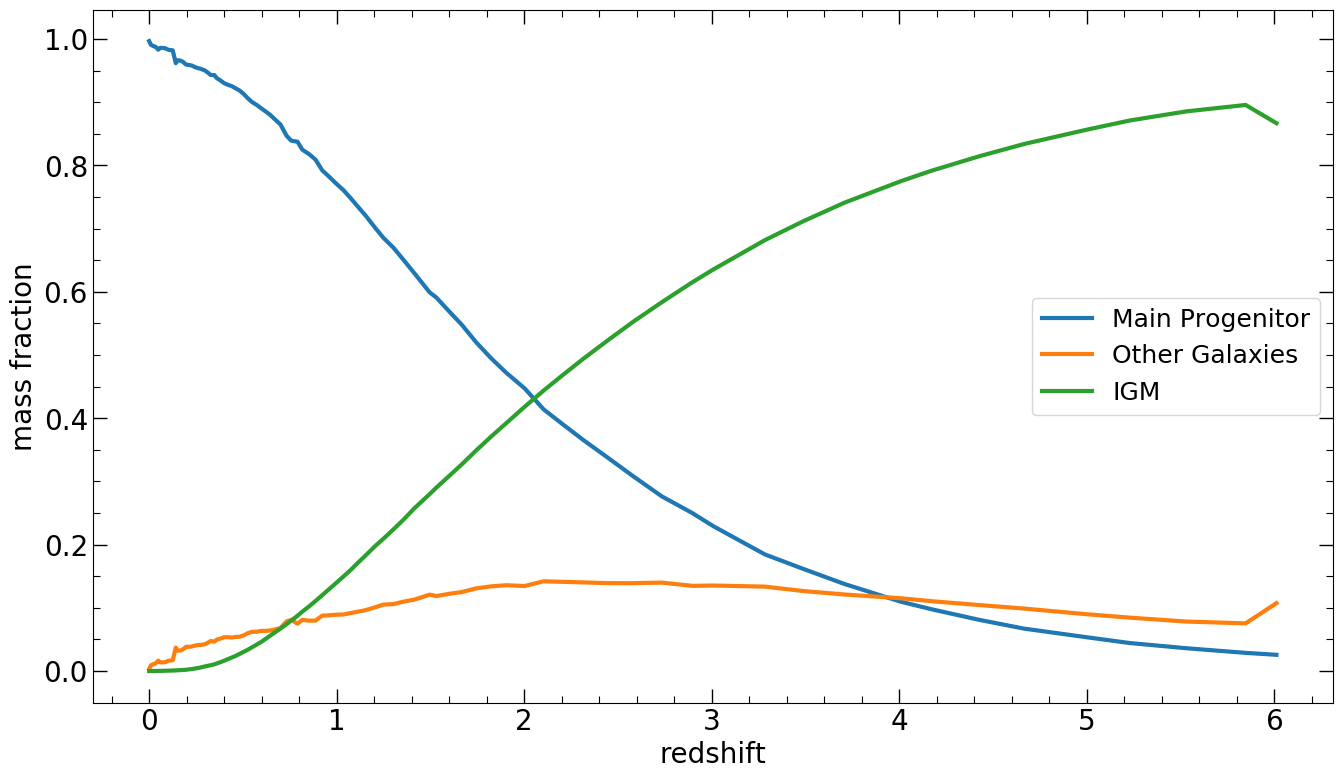

In [16]:
plt.plot(z, mp/total, label = 'Main Progenitor')
plt.plot(z, (sub - mp)/total, label = 'Other Galaxies')
plt.plot(z, igm/total, label = 'IGM')
#plt.plot(z,np.mean(gal_comp[:,:,0],axis=1),label='gal mp mean',linestyle = '-.',color = 'blue')
#plt.plot(z,np.mean(gal_comp[:,:,1],axis=1),label='gal others mean',linestyle = '-.',color = 'orange')
#plt.plot(z,np.mean(1 - gal_comp[:,:,0] - gal_comp[:,:,1],axis=1),label='gal igm mean',linestyle = '-.',color = 'green')
plt.legend()
plt.ylabel('mass fraction')
plt.xlabel('redshift')
#plt.xticks(z)
#plt.title('mass fraction in MP / other galaxies / IGM for MW-sized halos',size=18)
plt.savefig('pics/tracer_fraction_TNG50-1_overview.pdf',format='pdf')

Text(0.5, 1.0, 'mass fraction in MP / other galaxies / IGM')

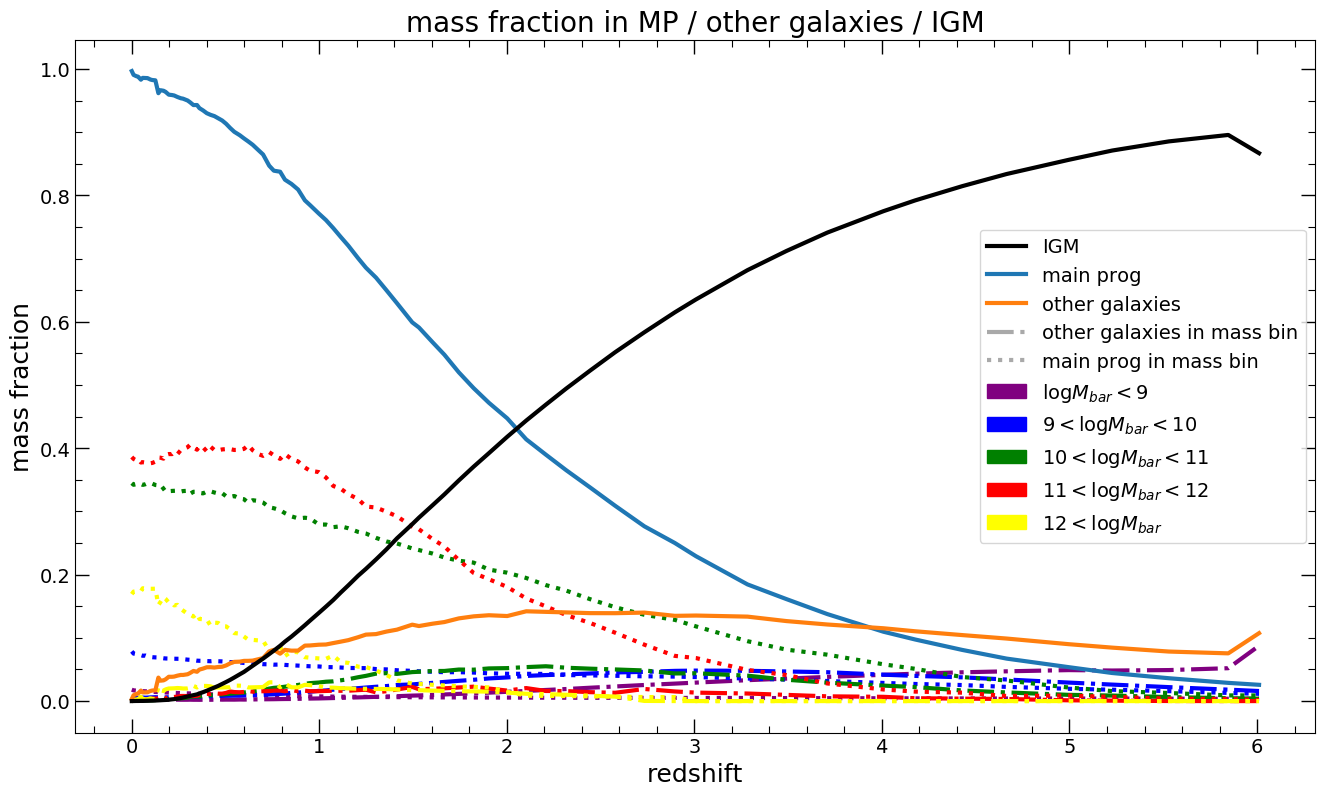

In [17]:
plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, color='black', label = 'IGM')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[IGM,MP,OTHER,dash,dotted,purple,blue,green,red,yellow], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction',size=18)
plt.xlabel('redshift',size=18)
plt.tick_params(labelsize = 14)
plt.title('mass fraction in MP / other galaxies / IGM',size=20)
#plt.savefig('pics/tracer_fraction_TNG50-3_everything_test.jpg',format='jpg')

### only MP

Text(0.5, 0, 'redshift')

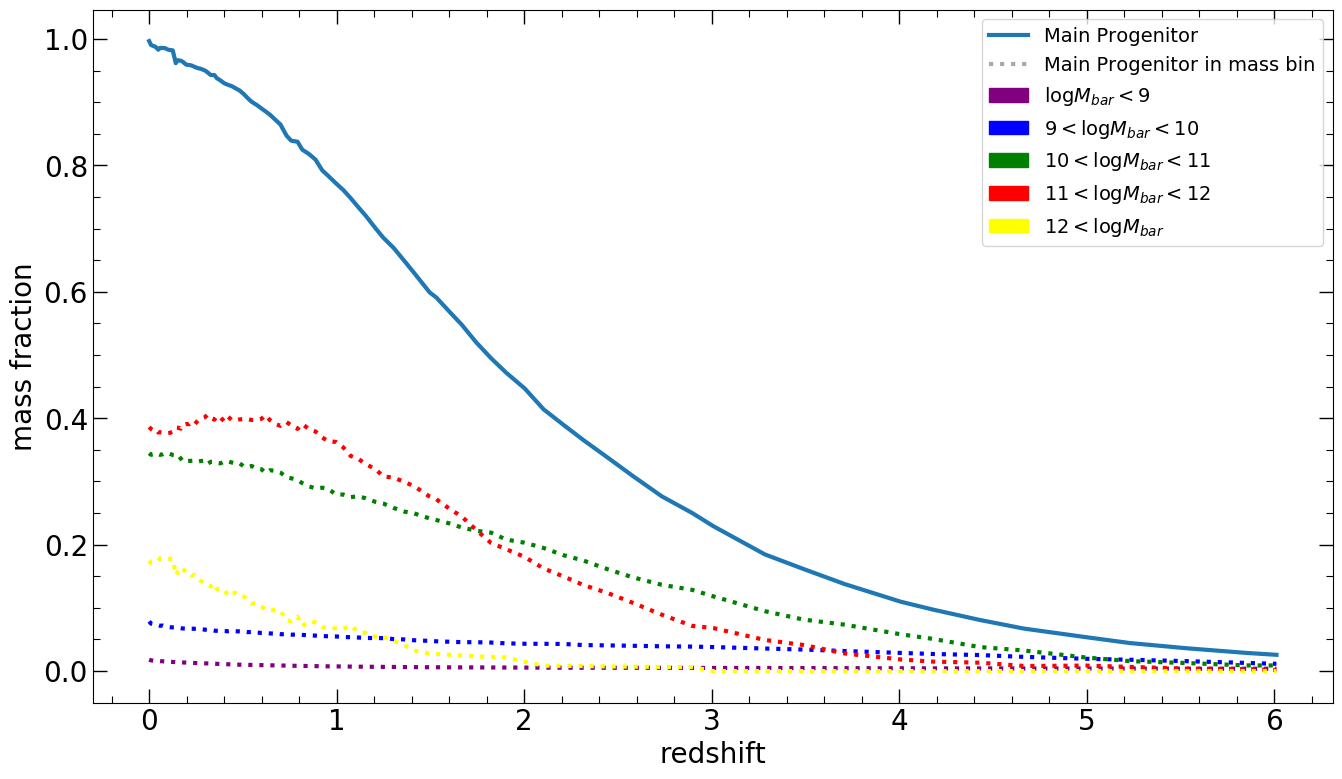

In [18]:
plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

plt.plot(z, mp/total, label = 'main prog')
#plt.plot(z,np.sum(nums[:,:,0],axis = 1)/total, label = 'check sum',color = 'black')

#plt.plot(z, (sub - mp)/total, label = 'other galaxies')
#plt.plot(z, igm/total, color='black', label = 'IGM')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='Main Progenitor')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='Main Progenitor in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[MP,dotted,purple,blue,green,red,yellow], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction')
plt.xlabel('redshift')
#plt.tick_params(labelsize = 14)
#plt.title('mass fraction in MP w/ mass bins',size=20)
#plt.savefig('pics/tracer_fraction_TNG50-1_onlyMP.pdf',format='pdf')

### only other galaxies

Text(0.5, 0, 'redshift')

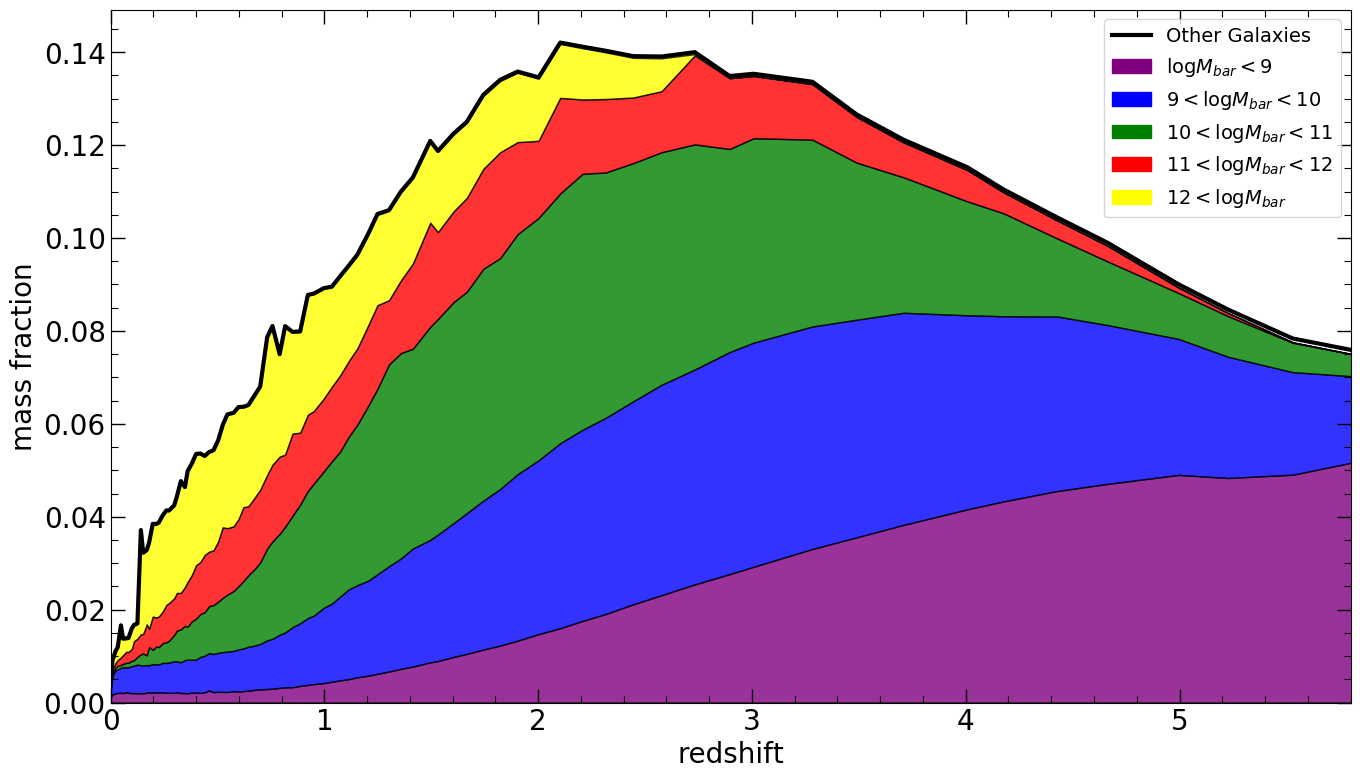

In [19]:
# #plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
# plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
# #plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
# plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
# #plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
# plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
# #plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
# plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
# #plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
# plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

y = np.vstack([nums[:,0,1]/total, nums[:,1,1]/total, nums[:,2,1]/total, nums[:,3,1]/total, nums[:,4,1]/total])

#plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies',color = 'black')
#plt.plot(z,np.sum(nums[:,:,1],axis = 1)/total, label = 'check sum',color = 'black')
#plt.plot(z, igm/total, color='black', label = 'IGM')
plt.stackplot(z,y, colors = ['purple','blue','green','red','yellow'], alpha = 0.8, edgecolor = 'black')

plt.xlim(0,5.8)

check = mlines.Line2D([], [], color='black', label='check sum')
IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='black', label='Other Galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='Other Galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[OTHER,purple,blue,green,red,yellow], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction')
plt.xlabel('redshift')
#plt.tick_params(labelsize = 14)
#plt.title('mass fraction in other galaxies w/ mass bins',size=20)
#plt.savefig('pics/ideas/tracer_fraction_TNG50-1_onlyOtherGalaxies_stacked.pdf',format='pdf')

### galaxy composition individually:

In [3]:
def z_x_igm(gal_comp,z,frac):
    """for every galaxy, it determines the redshift, after which less than x % of the mass is in the IGM"""
    z_igm = np.zeros(gal_comp.shape[1])
    for i in nb.prange(gal_comp.shape[1]):
        if np.all(1 - gal_comp[:,i,0] - gal_comp[:,i,1] == 0):
            z_igm[i] = np.nan
            continue
        elif np.all(1 - gal_comp[:,i,0] - gal_comp[:,i,1] < frac):
            z_igm[i] = z[97]
            continue
        t_igm = np.min(np.where(1 - gal_comp[:,i,0] - gal_comp[:,i,1] >= frac)[0]).astype(int)
        z_igm[i] = z[t_igm]
    return z_igm

In [4]:
def z_x_mp(gal_comp,z,frac):
    """for every galaxy, it determines the redshift, after which more than x % of the mass is in the MPB"""
    z_mp = np.zeros(gal_comp.shape[1])
    for i in range(gal_comp.shape[1]):
#         print(i,end=' ')
        if np.all(gal_comp[:,i,0] == 1):
            z_mp[i] = np.nan
            continue
        elif np.all(gal_comp[:,i,0] > frac):
            z_mp[i] = z[97]
            continue
        else:
            t_mp = np.min(np.where(gal_comp[:,i,0] <= frac)[0]).astype(int)
        z_mp[i] = z[t_mp]
    return z_mp

In [5]:
f = h5py.File('files/TNG50-1/fracs_w_mass_bins.hdf5','r')
gal_comp = f['galaxy_composition'][:,:,:]
z = f['redshift'][:]
sub_ids = f['subhalo_ids'][:]
f.close()

f = h5py.File('files/TNG50-1/fracs_w_mass_bins_groups.hdf5','r')
gal_comp_groups = f['galaxy_composition'][:,:,:]
sub_ids_groups = f['subhalo_ids'][:]
f.close()

f = h5py.File('files/TNG50-1/fracs_w_mass_bins_mw.hdf5','r')
gal_comp_mw = f['galaxy_composition'][:,:,:]
sub_ids_mw = f['subhalo_ids'][:]
f.close()

f = h5py.File('files/TNG50-1/fracs_w_mass_bins_dwarves.hdf5','r')
gal_comp_dwarfs = f['galaxy_composition'][:,:,:]
sub_ids_dwarfs = f['subhalo_ids'][:]
f.close()

In [6]:
bins_igm, z_igm = funcs.binData(z_x_igm(gal_comp, z, 0.5), 8, mode = 'sum')
bins_mp, z_mp = funcs.binData(z_x_mp(gal_comp, z, 0.5), 8, mode = 'sum')

bins_igm_groups, z_igm_groups = funcs.binData(z_x_igm(gal_comp_groups, z, 0.5), 8, mode = 'sum')
bins_mp_groups, z_mp_groups = funcs.binData(z_x_mp(gal_comp_groups, z, 0.5), 8, mode = 'sum')

bins_igm_mw, z_igm_mw = funcs.binData(z_x_igm(gal_comp_mw, z, 0.5), 8, mode = 'sum')
bins_mp_mw, z_mp_mw = funcs.binData(z_x_mp(gal_comp_mw, z, 0.5), 8, mode = 'sum')

bins_igm_dwarfs, z_igm_dwarfs = funcs.binData(z_x_igm(gal_comp_dwarfs, z, 0.5), 8, mode = 'sum')
bins_mp_dwarfs, z_mp_dwarfs = funcs.binData(z_x_mp(gal_comp_dwarfs, z, 0.5), 8, mode = 'sum')

/vera/u/olwitt/bachelor_thesis/funcs.py:137: RuntimeWarning: invalid value encountered in greater_equal
  indices=np.where(np.logical_and(val >= minVal + b*binWidth, val < minVal + (b+1)*binWidth))[0]
/vera/u/olwitt/bachelor_thesis/funcs.py:137: RuntimeWarning: invalid value encountered in less
  indices=np.where(np.logical_and(val >= minVal + b*binWidth, val < minVal + (b+1)*binWidth))[0]


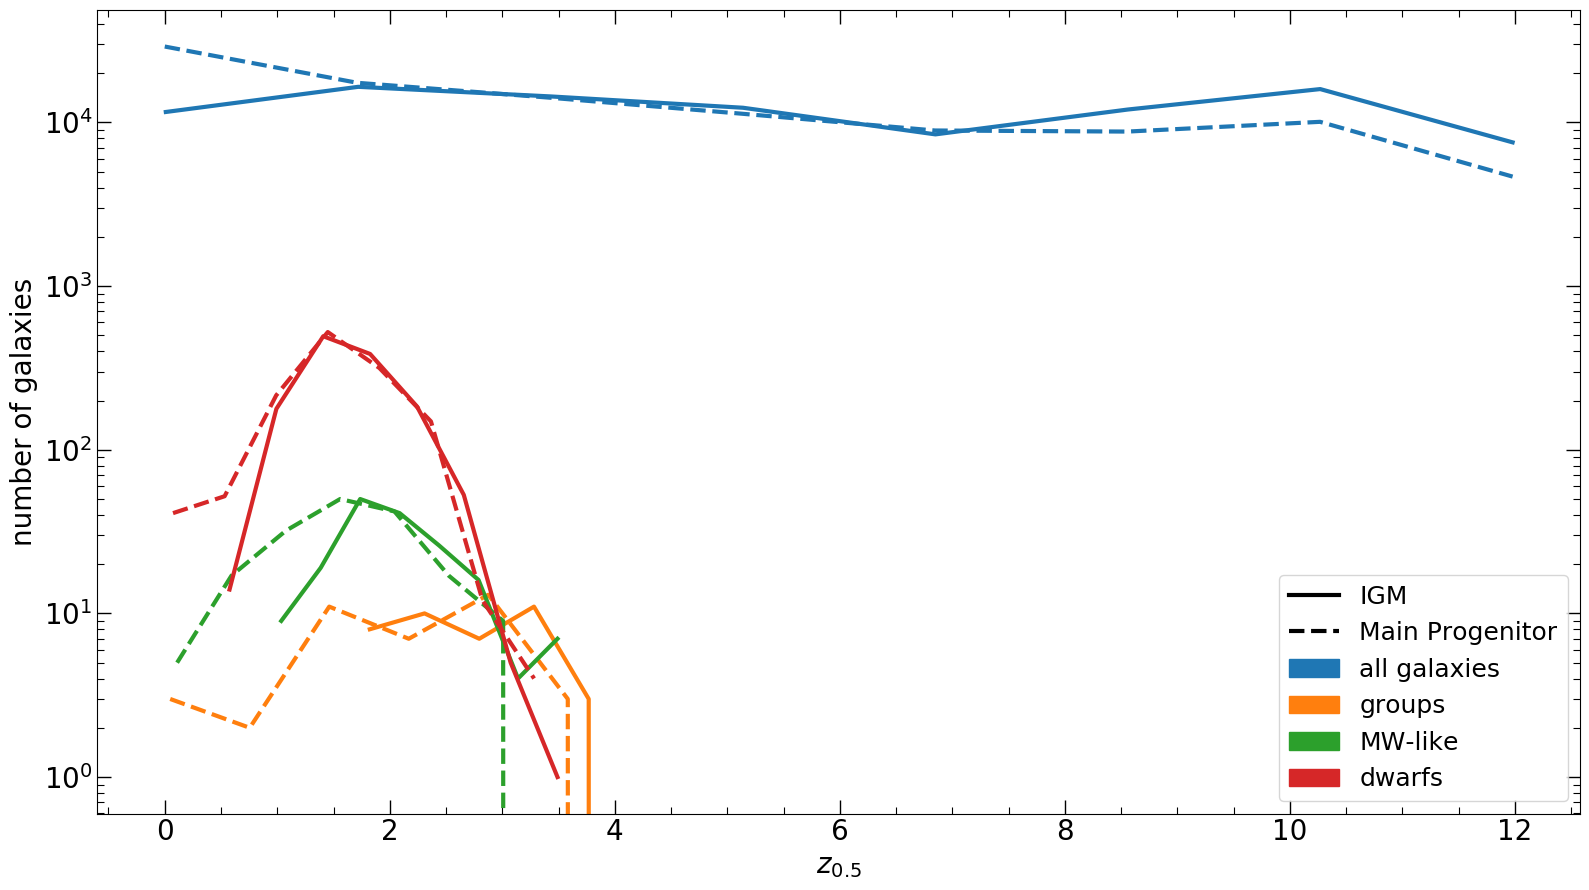

In [17]:
# plt.plot(bins_igm, z_igm/gal_comp.shape[1], color = 'C0')
# plt.plot(bins_mp, z_mp/gal_comp.shape[1], linestyle='dashed',color = 'C0')

# plt.plot(bins_igm_groups, z_igm_groups/gal_comp_groups.shape[1], color = 'C1')
# plt.plot(bins_mp_groups, z_mp_groups/gal_comp_groups.shape[1], linestyle='dashed',color = 'C1')

# plt.plot(bins_igm_mw, z_igm_mw/gal_comp_mw.shape[1], color = 'C2')
# plt.plot(bins_mp_mw, z_mp_mw/gal_comp_mw.shape[1], linestyle='dashed',color = 'C2')

# plt.plot(bins_igm_dwarfs, z_igm_dwarfs/gal_comp_dwarfs.shape[1], color = 'C3')
# plt.plot(bins_mp_dwarfs, z_mp_dwarfs/gal_comp_dwarfs.shape[1], linestyle='dashed',color = 'C3')

plt.plot(bins_igm, z_igm, color = 'C0')
plt.plot(bins_mp, z_mp, linestyle='dashed',color = 'C0')

plt.plot(bins_igm_groups, z_igm_groups, color = 'C1')
plt.plot(bins_mp_groups, z_mp_groups, linestyle='dashed',color = 'C1')

plt.plot(bins_igm_mw, z_igm_mw, color = 'C2')
plt.plot(bins_mp_mw, z_mp_mw, linestyle='dashed',color = 'C2')

plt.plot(bins_igm_dwarfs, z_igm_dwarfs, color = 'C3')
plt.plot(bins_mp_dwarfs, z_mp_dwarfs, linestyle='dashed',color = 'C3')

plt.yscale('log')

plt.xlabel('$z_{0.5}$')
plt.ylabel('fraction of galaxies')
plt.ylabel('number of galaxies')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='black', linestyle = 'dashed', label='Main Progenitor')

blue = mpatches.Patch(color='tab:blue', label='all galaxies')
green = mpatches.Patch(color='tab:green', label='MW-like')
red = mpatches.Patch(color='tab:red', label='dwarfs')
orange = mpatches.Patch(color='tab:orange', label='groups')

plt.legend(handles = [IGM, MP, blue, orange, green, red])
plt.tight_layout()
#plt.savefig('pics/tracer_fractions/z0.5_histogram_log.pdf', format = 'pdf')

In [15]:
basePath = '/virgotng/universe/IllustrisTNG/TNG50-1/output'
stellar_masses = np.log10(il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloMassType'])[:,4]* 1e10/h_const)
all_stellar_masses = stellar_masses[sub_ids]
group_stellar_masses = stellar_masses[sub_ids_groups]
mw_stellar_masses = stellar_masses[sub_ids_mw]
dwarf_stellar_masses = stellar_masses[sub_ids_dwarfs]

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [8]:
frac_igm = 0.5
frac_mp = 0.5
z_igm = z_x_igm(gal_comp, z, frac_igm)
z_mp = z_x_mp(gal_comp, z, frac_mp)

percent = 100 * frac_mp

In [9]:
mask = np.where(stellar_masses > 8)
xmed_mp, ymed_mp, y16_mp, y84_mp = funcs.binData_med(stellar_masses[mask], z_mp[mask], 20)
xmed_igm, ymed_igm, y16_igm, y84_igm = funcs.binData_med(stellar_masses[mask], z_igm[mask], 20)

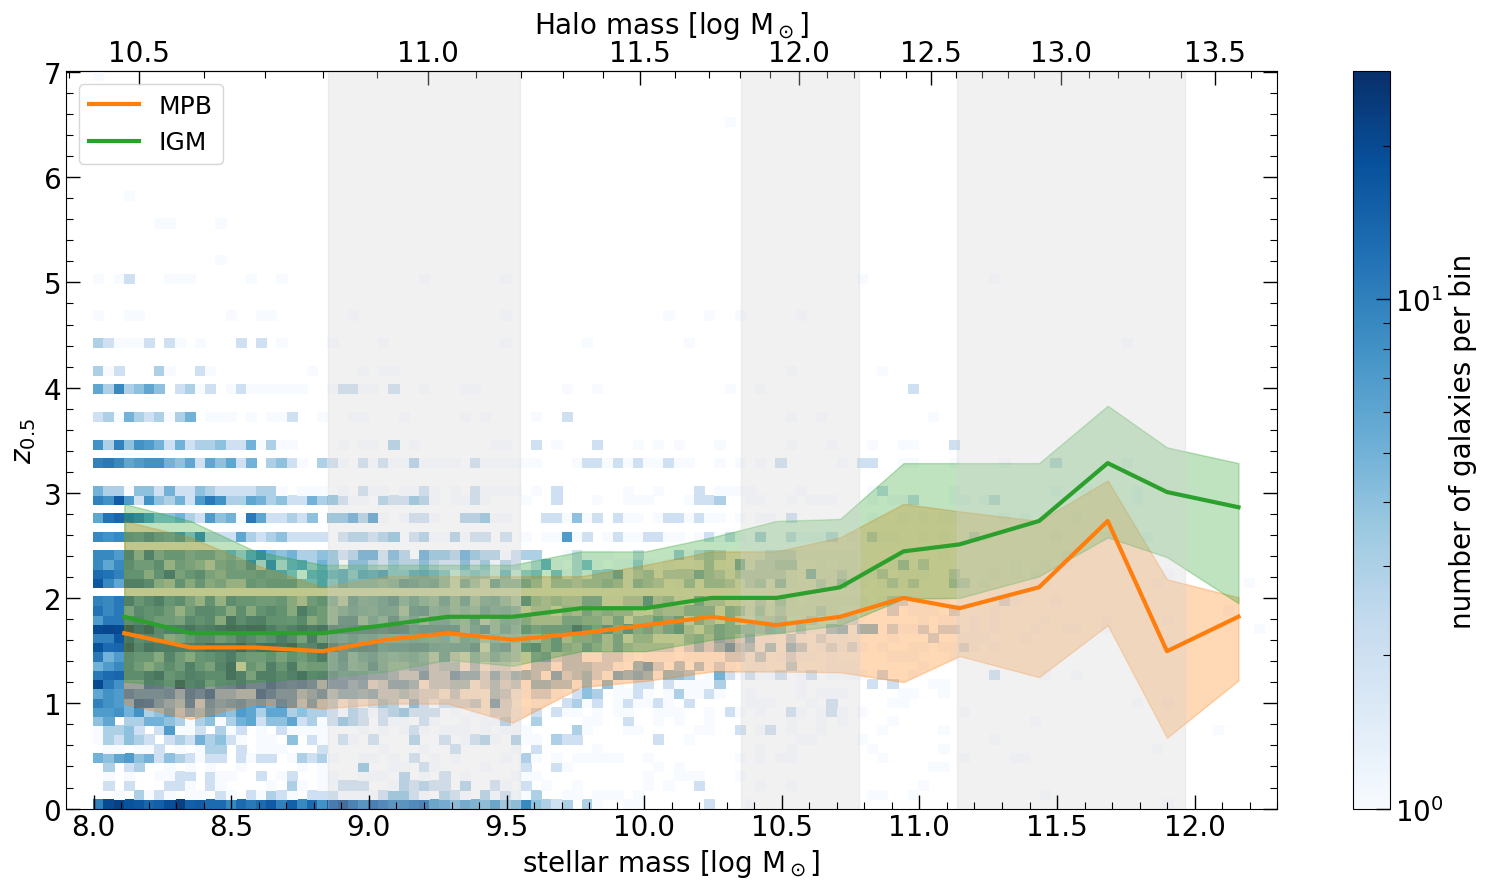

In [12]:
from matplotlib.patches import Rectangle

#compute median stellar mass halo mass relation
def stellar_to_halo_mass_relation(stellar_masses):
    #return -2.1e-2 * stellar_masses**3 + 8.5e-1 * stellar_masses**2 -10*stellar_masses + 47.6
    return -1.1622e-04 * stellar_masses**3 + 9.1634e-02 * stellar_masses**2 - 1.0706 * stellar_masses +  13.192

def halo_to_stellar_mass_relation(halo_masses):
    #return 8.4e-2 * halo_masses**3 -3.3 * halo_masses**2 + 45.3 * halo_masses - 196
    return 1.2688e-01 * halo_masses**3 -4.7718 * halo_masses**2 + 60.772 * halo_masses -250.8

with mpl.rc_context({'xtick.top' : False}):
    fig, ax = plt.subplots(1,1,tight_layout = True)
_, xedges, yedges, _ = plt.hist2d(stellar_masses[mask], z_mp[mask], cmap='Blues',bins = (128,80),\
                                  norm = mpl.colors.LogNorm())
plt.colorbar(label = 'number of galaxies per bin')

rec_dwarf = Rectangle((halo_to_stellar_mass_relation(10.83),-0.1),0.7,7.5, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_dwarf)
rec_mw = Rectangle((halo_to_stellar_mass_relation(11.8),-0.1),0.43,7.5, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_mw)
rec_group = Rectangle((halo_to_stellar_mass_relation(12.57),-0.1),0.83,7.5, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_group)

plt.plot(xmed_mp, ymed_mp, color='tab:orange', label = 'MPB')
plt.fill_between(xmed_mp, y16_mp, y84_mp, color='tab:orange', alpha=0.3)
plt.plot(xmed_igm, ymed_igm, color = 'tab:green', label = 'IGM')
plt.fill_between(xmed_igm, y16_igm, y84_igm, color='tab:green', alpha=0.3)

secax = ax.secondary_xaxis('top',functions = (stellar_to_halo_mass_relation,halo_to_stellar_mass_relation))
secax.set_xlabel(r'Halo mass [log $\rm{M}_\odot$]')



plt.ylabel(r'$z_{0.5}$')
plt.xlabel(r'stellar mass [log $\rm{M}_\odot$]')
plt.legend()
plt.xlim(7.9,12.3)
plt.tight_layout()
    #plt.yscale('symlog')
    #plt.savefig(f'pics/z_0.5_igm_mp.pdf',format = 'pdf')

In [129]:
print(np.abs(xedges[0]-xedges[-1])/xedges.size)
print(np.abs(yedges[0]-yedges[-1])/yedges.size)

0.0367079963979795
0.08648663019190782


In [17]:
print(sub_ids.shape)

(113496,)
